In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import time

import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import matplotlib.pyplot as plt

In [ ]:
!pip install torchsummary --quiet
# from torchsummaryX import summary as summaryX
from torchsummary import summary

## Model

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_class):
        super(LeNet, self).__init__()
   
        # in_channel, output_channel, kernel_size, stride, padding
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        
        # self.conv3 = nn.Conv2d(16, 120, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, num_class) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)

        probs = F.softmax(logits, dim=1)

        return logits, probs
        


In [ ]:
# GPU available
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

# hyperparameter
lr = 0.001
batch_size = 32
random_seed = 42
epoches = 10
log_every_epoch = 1

# model parameter 
num_class = 10


In [ ]:
model = LeNet(num_class).to(device)

print(model)


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
summary(model, (1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
            Conv2d-2           [-1, 16, 10, 10]           2,416
            Linear-3                  [-1, 120]          48,120
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


## Dataset

In [ ]:
img_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])


In [ ]:
# root => the location to save the data
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=img_transforms)


In [ ]:
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=img_transforms)


In [ ]:
len(train_set), len(test_set)


(60000, 10000)

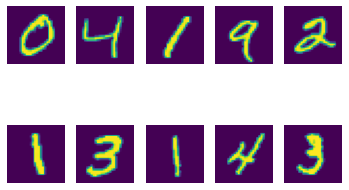

In [ ]:
col = 5
row = 2

fig = plt.figure()
for index in range(1, row * col + 1):
    plt.subplot(row, col, index)
    plt.axis('off')
    plt.imshow(train_set.data[index])

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)


## Train

In [ ]:
torch.manual_seed(random_seed)

model = LeNet(num_class).to(device)
optimiser = optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()


In [ ]:
def train():
    print('=== training ===')
    start_time = time.time()

    train_loss_epoch = []
    valid_loss_epoch = []
    for epoch in range(epoches):
        model.train()

        train_loss = 0
        train_num_correct = 0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
          
            y_pred, probs = model(X)
            loss = loss_fn(y_pred, y)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            with torch.no_grad():
              train_loss += loss.item() * len(X)
              _, preds = probs.max(1)
              train_num_correct += (preds == y).sum()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_num_correct / len(train_loader.dataset)
        train_loss_epoch.append( epoch_train_loss )
    
    
        # validation
        if epoch == 0 or (epoch + 1) % log_every_epoch == 0:
            model.eval()
        
            with torch.no_grad():
              valid_loss = 0
              valid_num_correct = 0
              for X_t, y_t in test_loader:
                  X_t = X_t.to(device)
                  y_t = y_t.to(device)
                  y_t_pred, probs_t = model(X_t)
                  loss_t = loss_fn(y_t_pred, y_t)

                  valid_loss += loss_t.item() * len(X_t)    
                  _, preds_t = probs_t.max(1)
                  valid_num_correct += (preds_t == y_t).sum()

            epoch_valid_loss = valid_loss / len(test_loader.dataset)
            epoch_valid_acc = valid_num_correct / len(test_loader.dataset)
            valid_loss_epoch.append( epoch_valid_loss )

            print('epoch %d/%d, Train loss: %.4f, Train acc %.4f, Valid loss: %.4f, Valid acc %.4f' % 
                  ( epoch + 1, epoches, epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc)
            )

    print('Training time: {}'.format(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))))

In [ ]:

train()


=== training ===
epoch 1/10, Train loss: 0.2105, Train acc 0.9352, Valid loss: 0.0792, Valid acc 0.9754
epoch 2/10, Train loss: 0.0658, Train acc 0.9798, Valid loss: 0.0513, Valid acc 0.9840
epoch 3/10, Train loss: 0.0454, Train acc 0.9863, Valid loss: 0.0402, Valid acc 0.9865
epoch 4/10, Train loss: 0.0375, Train acc 0.9885, Valid loss: 0.0480, Valid acc 0.9844
epoch 5/10, Train loss: 0.0301, Train acc 0.9909, Valid loss: 0.0370, Valid acc 0.9872
epoch 6/10, Train loss: 0.0255, Train acc 0.9917, Valid loss: 0.0310, Valid acc 0.9893
epoch 7/10, Train loss: 0.0210, Train acc 0.9934, Valid loss: 0.0398, Valid acc 0.9871
epoch 8/10, Train loss: 0.0181, Train acc 0.9940, Valid loss: 0.0396, Valid acc 0.9898
epoch 9/10, Train loss: 0.0156, Train acc 0.9952, Valid loss: 0.0429, Valid acc 0.9882
epoch 10/10, Train loss: 0.0147, Train acc 0.9954, Valid loss: 0.0392, Valid acc 0.9901
Training time: 00:03:11
